In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import matplotlib.gridspec as gridspec
import os, sys, math
os.chdir("..")
from Source.Models.autoregGMM import AutoRegGMM
from torch.nn import functional as F
from Source.Util.util import load_params, get, get_device
import torch
from torch.utils.data import DataLoader
from Source.Util.simulateToyData import ToySimulator

In [2]:
def getAttentionMatrix(model, params, idx):
    b, t = idx.size()
    pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)
    idx = idx.reshape(idx.size(0), idx.size(1), 1)
    tok_emb = model.net.transformer.wte(idx)        
    pos_emb = model.net.transformer.wpe(pos)
    x = model.net.transformer.drop(tok_emb + pos_emb)
    
    B, T, C = x.size()
    n_head = params["n_head"]
    q, k ,v  = model.net.transformer.h[0].attn.c_attn(x).split(params["intermediate_dim"], dim=2)
    k = k.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
    q = q.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
    v = v.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
    
    att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
    att = att.masked_fill(model.net.transformer.h[0].attn.bias[:,:,:T,:T] == 0, float('-inf'))
    att = F.softmax(att, dim=-1)
    #att = model.net.transformer.h[0].attn.attn_dropout(att) #not used for evaluation
    
    return att.detach().cpu().numpy()

In [3]:
def plotMultiAttMatrixOld(attIn, isample=0, fSize=12, labels=None, rotateLower=0):
    n_features = attIn.shape[2]
    n_heads = attIn.shape[1]
    if labels==None:
        labels = [f"$x_{i}$" for i in range(n_features)]
    
    fig, axs = plt.subplots(1, n_heads, figsize=(4*n_heads,4))
    if n_heads == 1:
        axs = [axs]
    for ihead in range(n_heads):
        # attention matrix
        att = attIn[isample, ihead, :, :]
        axs[ihead].imshow(att, cmap="Reds")
        
        # mask
        n = len(labels)
        mask = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                mask[i,j] = i<j
        axs[ihead].imshow(mask, cmap="Greys", vmin=0., vmax=1., alpha=.5)
        
        # grid
        minor_locator =FixedLocator(np.arange(len(labels)+1)-.5)
        axs[ihead].xaxis.set_minor_locator(minor_locator)
        axs[ihead].yaxis.set_minor_locator(minor_locator)    
        axs[ihead].grid(which="minor", alpha=.5, lw=.5)
        axs[ihead].tick_params(axis='x', which='minor', bottom=False)
        axs[ihead].tick_params(axis='y', which='minor', left=False)
        
        # labels
        axs[ihead].set_xticks(np.arange(len(labels)))
        axs[ihead].set_xticklabels([r"$%s$" % labels[i] for i in range(len(labels))], 
                                   fontsize=fSize, rotation=rotateLower)
        axs[ihead].set_yticks(np.arange(len(labels)))
        axs[ihead].set_yticklabels([r"$%s$" % labels[i] for i in range(len(labels))], 
                                   fontsize=fSize, rotation=0)
    #fig.suptitle(f"Attention matrices for event {isample}")
    #fig.savefig(f"Scripts/attmatrix_{isample}.pdf", bbox_inches="tight")
    plt.show()

In [4]:
def plotMultiAttMatrix(attIn, isample=0, fSize=20, labels=None, rotateLower=0):
    n_features = attIn.shape[2]
    n_heads = attIn.shape[1]
    if labels==None:
        labels = [f"$x_{i}$" for i in range(n_features)]
    
    fig = plt.figure(figsize=(16,16))
    gspec = gridspec.GridSpec(ncols=4, nrows=1, figure=fig)
    for ihead in range(n_heads):
        # attention matrix
        att = attIn[isample, ihead, :, :]
        
        ax = plt.subplot(gspec[ihead], frameon=False)
        for i in range(-1, n_features):
            ax.axhline(i+.5, color="white", lw=1)
            ax.axvline(i+.5, color="white", lw=1)
        
        mask = np.tri(n_features, dtype="int")
        mask = np.ma.array(mask+1., mask=mask)
        ax.imshow(att, cmap="Reds", alpha=.8, vmin=0.)
        ax.imshow(mask, cmap="Greys", alpha=.6, vmin=0., vmax=1.)
    
        # labels
        ax.set_xticks(np.arange(len(labels)))
        ax.set_xticklabels([r"$%s$" % labels[i] for i in range(len(labels))], 
                                   fontsize=fSize, rotation=rotateLower)
        ax.set_yticks(np.arange(len(labels)))
        ax.set_yticklabels([r"$%s$" % labels[i] for i in range(len(labels))], 
                                   fontsize=fSize, rotation=0)
        ax.tick_params(axis="x", which="both", bottom=False)
        ax.tick_params(axis="y", which="both", left=False)
    #fig.suptitle(f"Attention matrices for event {isample}")
    fig.savefig(f"Scripts/attmatrix_{n_heads}head_{isample}.pdf", bbox_inches="tight")
    plt.show()

In [5]:
# random data
params = {"toy_type": "gauss_sphere", "dim": 5, "n_data": 1000}
data = torch.Tensor(ToySimulator(params).data)[:10,:]

In [6]:
# inspired data
data = torch.zeros(5,5)
data[0,:] = torch.Tensor([1,0,0,0,0])
data[1,:] = torch.Tensor([0,1,0,0,0])
data[2,:] = torch.Tensor([0,0,1,0,0])
data[3,:] = torch.Tensor([0,0,0,1,0])
data[4,:] = torch.Tensor([0,0,0,0,1])

# 4-headed attention

In [7]:
runpath = "runs/set26_sphereAtt_5d_4head_det/"

### Load data

In [8]:
modelpath = runpath + "models/model_run0.pt"
parampath = runpath + "paramfile.yaml"
params = load_params(parampath)
device=get_device()
params["device"] =device

In [9]:
model = AutoRegGMM(params)
state_dict = torch.load(modelpath, map_location=params["device"])
model.load_state_dict(state_dict)
model.eval(); #disable dropout

Model AutoRegGMM hyperparameters: n_head=4, n_per_head=16, n_blocks=1, intermediate_fac=4, n_gauss=21
Bayesianization hyperparameters: bayesian=0, prior_prec=1.0, iterations=1


In [10]:
att = getAttentionMatrix(model, params, data[:100,:])
print(np.shape(att))

(5, 4, 5, 5)


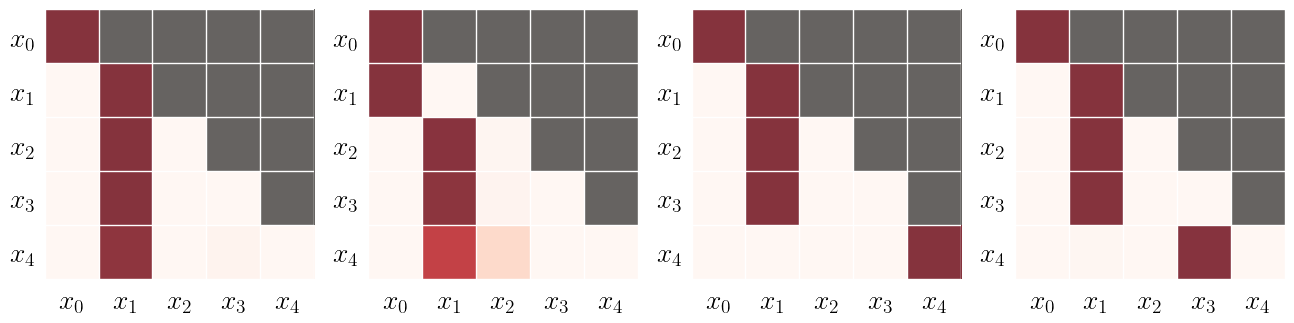

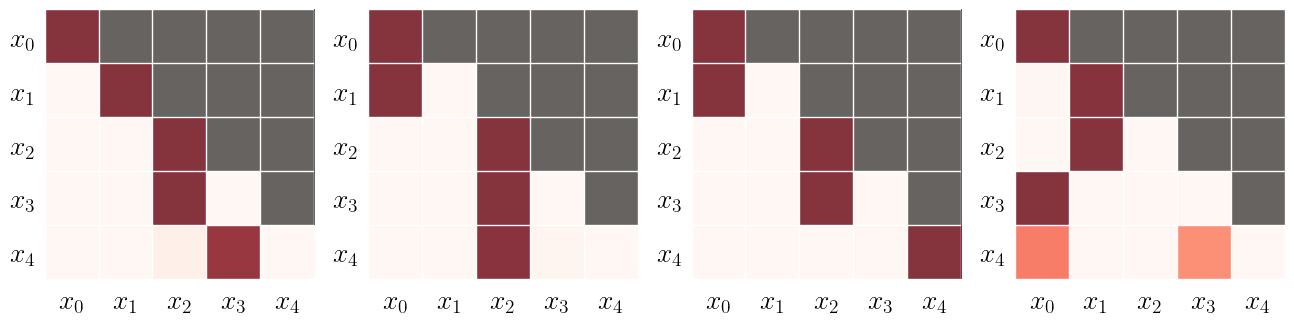

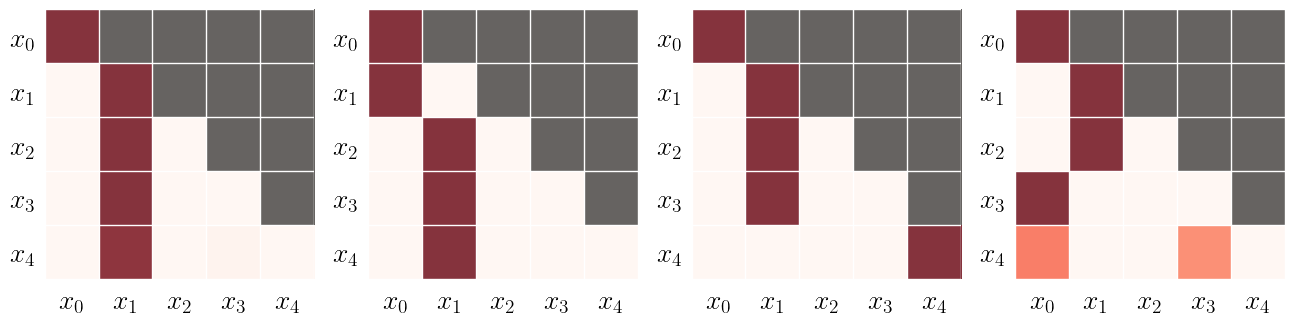

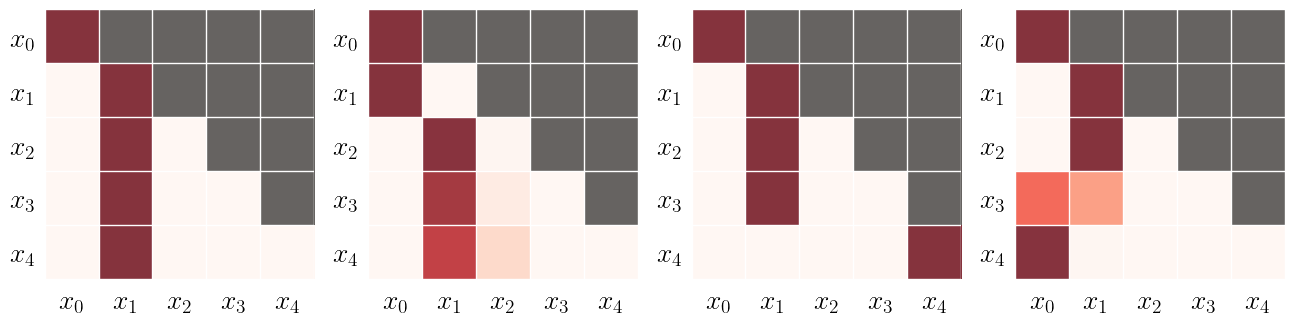

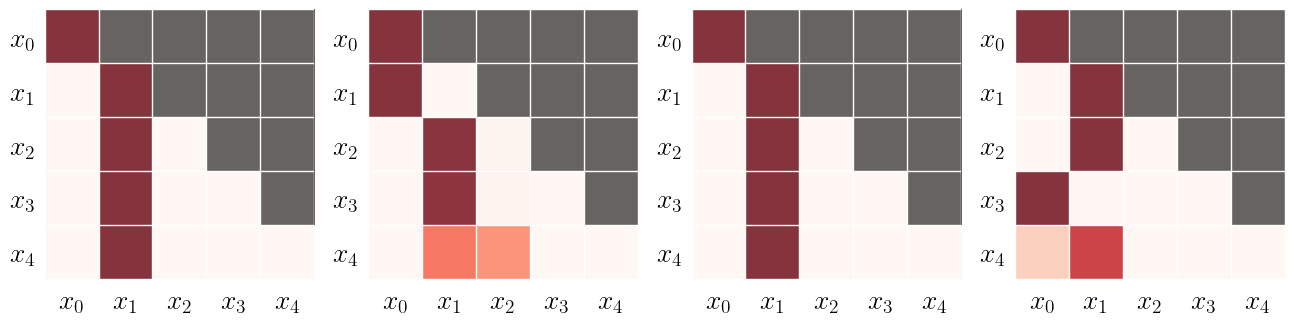

In [11]:
for isample in range(data.shape[0]):
    plotMultiAttMatrix(att, isample=isample)

# 2-headed attention

In [12]:
runpath = "runs/set26_sphereAtt_5d_2head_det/"

In [13]:
modelpath = runpath + "models/model_run0.pt"
parampath = runpath + "paramfile.yaml"
params = load_params(parampath)
device=get_device()
params["device"] =device

In [14]:
model = AutoRegGMM(params)
state_dict = torch.load(modelpath, map_location=params["device"])
model.load_state_dict(state_dict)
model.eval();

Model AutoRegGMM hyperparameters: n_head=2, n_per_head=32, n_blocks=1, intermediate_fac=4, n_gauss=21
Bayesianization hyperparameters: bayesian=0, prior_prec=1.0, iterations=1


In [15]:
att = getAttentionMatrix(model, params, data[:100,:])
print(np.shape(att))

(5, 2, 5, 5)


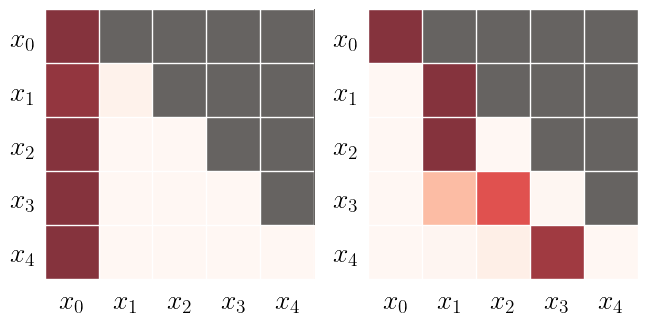

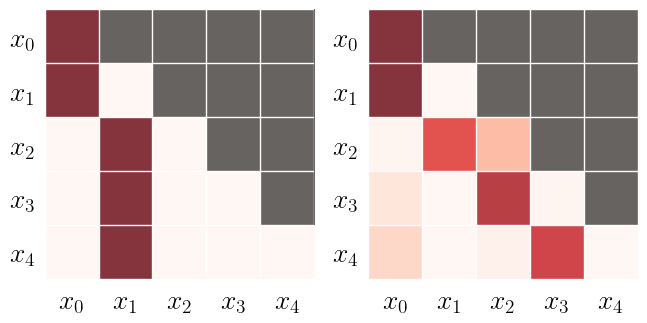

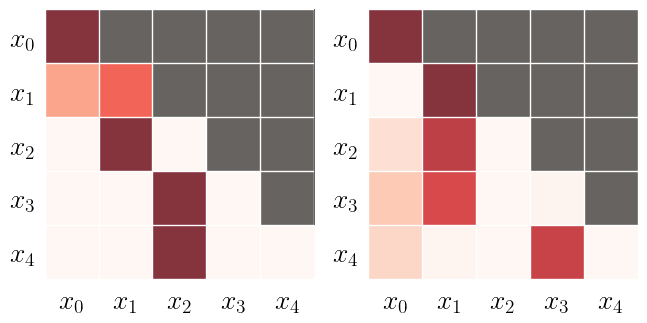

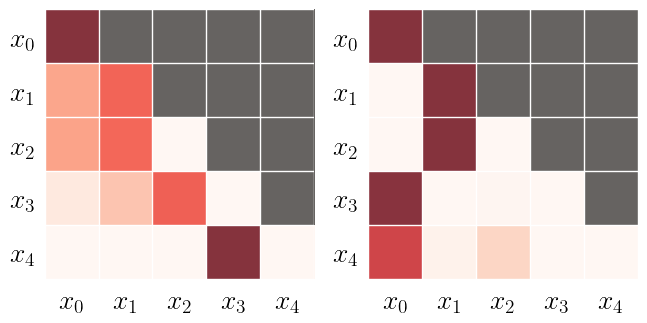

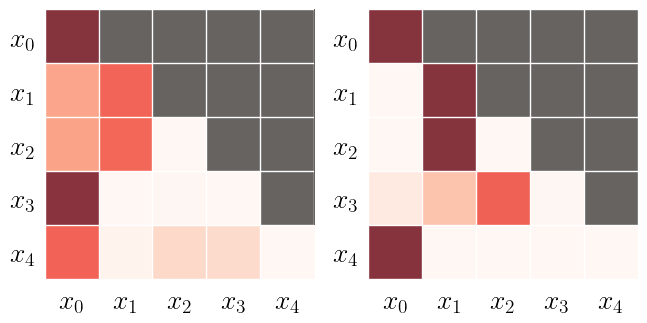

In [16]:
for isample in range(data.shape[0]):
    plotMultiAttMatrix(att, isample=isample)

# 1-headed attention

In [17]:
runpath = "runs/set26_sphereAtt_5d_1head_det/"

In [18]:
modelpath = runpath + "models/model_run0.pt"
parampath = runpath + "paramfile.yaml"
params = load_params(parampath)
device=get_device()
params["device"] =device

In [19]:
model = AutoRegGMM(params)
state_dict = torch.load(modelpath, map_location=params["device"])
model.load_state_dict(state_dict)
model.eval();

Model AutoRegGMM hyperparameters: n_head=1, n_per_head=64, n_blocks=1, intermediate_fac=4, n_gauss=21
Bayesianization hyperparameters: bayesian=0, prior_prec=1.0, iterations=1


In [20]:
att = getAttentionMatrix(model, params, data[:100,:])
print(np.shape(att))

(5, 1, 5, 5)


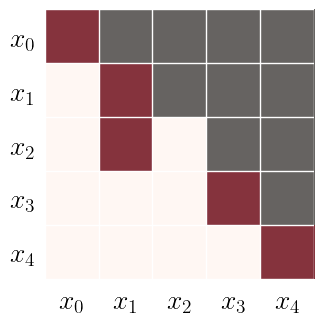

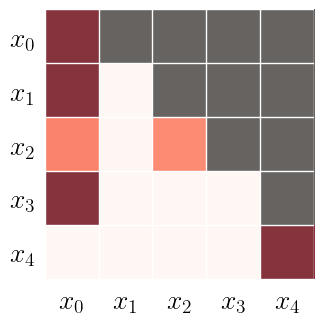

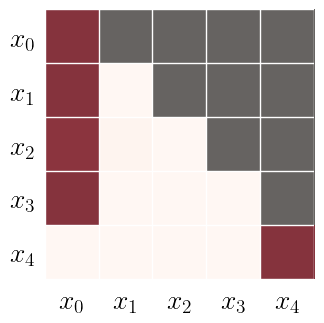

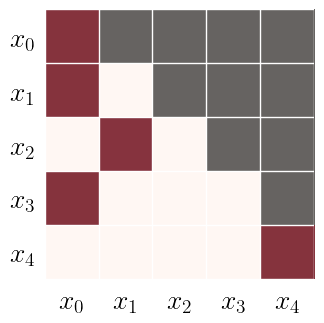

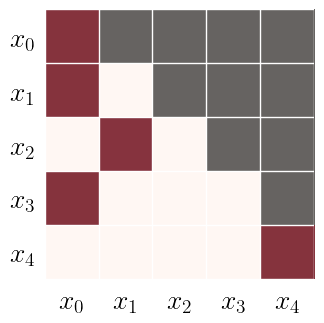

In [21]:
for isample in range(data.shape[0]):
    plotMultiAttMatrix(att, isample=isample)